# Package and datasets

In [4]:
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.ensemble import IsolationForest
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import classification_report
dataset_path = "D:\\Casper\\OTHER\\Data\\MNIST_data"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [5]:
def filter_indices(dataset, classes):
    indices = []
    for i in range(len(dataset)):
        if dataset.targets[i] in classes:
            indices.append(i)
    return indices

transform = transforms.Compose([
    transforms.ToTensor(), 
    # transforms.Normalize((0.5,), (0.5,))
    ])
full_dataset = datasets.MNIST(root=dataset_path, train=True, download=False, transform=transform)

filtered_indices = filter_indices(full_dataset, [1, 3, 5, 7])
filtered_dataset = Subset(full_dataset, filtered_indices)
print(f"Full dataset: {len(full_dataset)}")
print(f"Filtered dataset: {len(filtered_dataset)}")


Full dataset: 60000
Filtered dataset: 24559


Label: 0


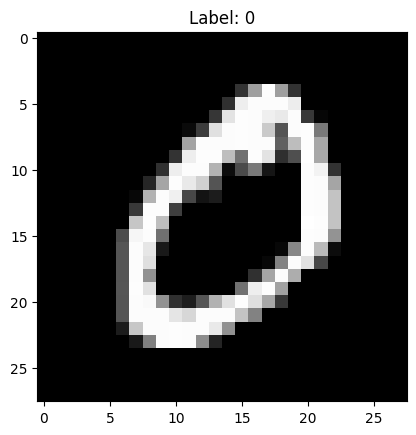

Label: 1


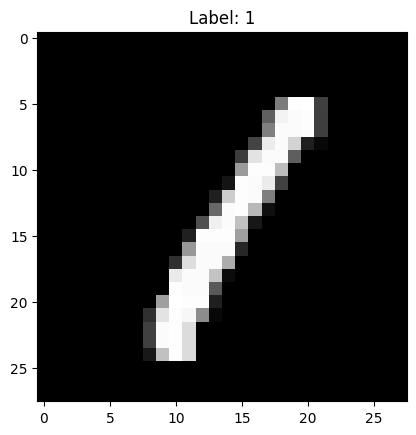

In [6]:
def display_image_and_tensor(dataset, index):
    image, label = dataset[index]  # Get the first image and its label
    
    print("Label:", label)
    image_np = image.squeeze().numpy()  

    plt.imshow(image_np, cmap='gray')
    plt.title(f'Label: {label}')
    plt.show()

display_image_and_tensor(full_dataset, 1)
display_image_and_tensor(filtered_dataset, 1)

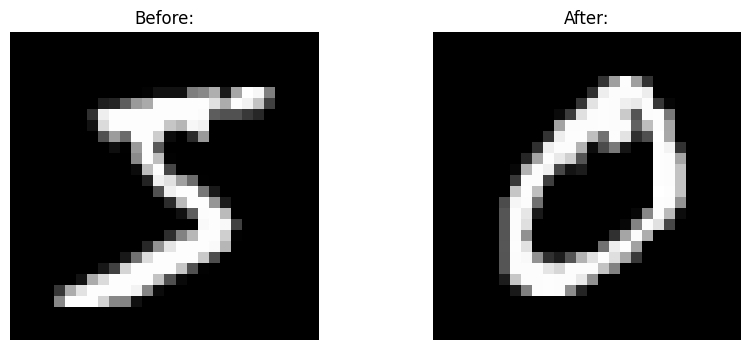

In [7]:
def plot_two_tensors(tensor1, tensor2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Create a figure with two subplots

    axes[0].imshow(tensor1.squeeze(), cmap='gray')  # Remove channel dimension if exists and plot
    axes[0].set_title(f'Before:')
    axes[0].axis('off')  # Hide axes ticks

    axes[1].imshow(tensor2.squeeze(), cmap='gray')
    axes[1].set_title(f'After:')
    axes[1].axis('off')

    plt.show()
plot_two_tensors(full_dataset[0][0], full_dataset[1][0])  

In [8]:

def get_dataloaders(dataset, train_ratio, val_ratio, batch_size, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    train_dataset = dataset
    val_dataset = dataset
    test_dataset = dataset
    # obtain training indices that will be used for validation
    num_train = len(test_dataset)
    indices = list(range(num_train))
    print("--------- INDEX checking ---------")
    print(f"Original: {indices[:5]}")
    random.shuffle(indices)
    print(f"Shuffled: {indices[:5]}")
    print("--------- INDEX shuffled ---------\n")

    split_train = int(np.floor(train_ratio * num_train))
    split_val = split_train + int(np.floor(val_ratio * (num_train-split_train)))
    train_idx, val_idx, test_idx = indices[0:split_train], indices[split_train:split_val], indices[split_val:]
    merge_dataset = Subset(train_dataset, train_idx)

    train_loader = DataLoader(merge_dataset, batch_size=batch_size)
    val_loader = DataLoader(Subset(val_dataset, val_idx), batch_size=batch_size)
    test_loader = DataLoader(Subset(test_dataset, test_idx), batch_size=batch_size)
    
    # check dataset
    print(f"Total number of samples: {num_train} datapoints")
    print(f"Number of train samples: {len(train_loader)} batches/ {len(train_loader.dataset)} datapoints")
    print(f"Number of val samples: {len(val_loader)} batches/ {len(val_loader.dataset)} datapoints")
    print(f"Number of test samples: {len(test_loader)} batches/ {len(test_loader.dataset)} datapoints")
    print(f"")
    
    dataloaders = {
        "train": train_loader,
        "val": val_loader,
        "test": test_loader,
    }
    return dataloaders
dataloaders = get_dataloaders(filtered_dataset, 0.8, 1, 64, 666)
full_dataloaders = get_dataloaders(full_dataset, 0.8, 1, 64, 666)


--------- INDEX checking ---------
Original: [0, 1, 2, 3, 4]
Shuffled: [7928, 6963, 6078, 12524, 11416]
--------- INDEX shuffled ---------

Total number of samples: 24559 datapoints
Number of train samples: 307 batches/ 19647 datapoints
Number of val samples: 77 batches/ 4912 datapoints
Number of test samples: 0 batches/ 0 datapoints

--------- INDEX checking ---------
Original: [0, 1, 2, 3, 4]
Shuffled: [41608, 20621, 29401, 29192, 11631]
--------- INDEX shuffled ---------

Total number of samples: 60000 datapoints
Number of train samples: 750 batches/ 48000 datapoints
Number of val samples: 188 batches/ 12000 datapoints
Number of test samples: 0 batches/ 0 datapoints



In [9]:
def count_parameters(model):
    total_num = 0

    for parameter in model.parameters():
        if parameter.requires_grad:
            total_num += parameter.numel() 
    return total_num

## 1. Image Classifier

In [18]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # Output: 16 x 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                # Output: 16 x 14 x 14
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),# Output: 32 x 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_net = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
        )
        self.fc = nn.Linear(128, len([1, 3, 5, 7]))

    def forward(self, x):
        x = self.conv_net(x)
        x = x.view(x.size(0), -1)
        x = self.fc_net(x)
        x = self.fc(x)
        return x


### Train image classifier

In [84]:
label_mapping = {1: 0, 3: 1, 5: 2, 7: 3}

def transform_labels(labels):
    transformed_labels = torch.tensor([label_mapping[label.item()] for label in labels])
    return transformed_labels


In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DigitClassifier().to(device)
print(f"Model: DigitClassifier")
model_parameters_amount = count_parameters(model)
print(f"model total parameters: {model_parameters_amount:,}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
epochs = 20

for epoch in range(epochs):
    model.train()
    correct, total = 0, 0
    running_loss = 0.0
    for images, labels in tqdm(dataloaders['train']):
        labels = transform_labels(labels)
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}\n[TRAIN] Accuracy: {100 * correct / total:.2f}%, Loss: {running_loss / total}')

    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(dataloaders['val']):
            labels = transform_labels(labels)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    print(f'[VALID] Accuracy: {100 * correct / total:.2f}%, Loss: {running_loss / total}\n')

model_scripted = torch.jit.script(model.cpu()) # Export to TorchScript
model_scripted.save('model_image_classifier.pt') # Save

Model: DigitClassifier
model total parameters: 206,148


100%|██████████| 307/307 [00:02<00:00, 109.27it/s]


Epoch 1
[TRAIN] Accuracy: 96.60%, Loss: 0.001476280243835085


100%|██████████| 77/77 [00:00<00:00, 163.83it/s]


[VALID] Accuracy: 99.17%, Loss: 0.000462797638519928



100%|██████████| 307/307 [00:02<00:00, 118.08it/s]


Epoch 2
[TRAIN] Accuracy: 99.33%, Loss: 0.000332061496989632


100%|██████████| 77/77 [00:00<00:00, 208.11it/s]


[VALID] Accuracy: 99.25%, Loss: 0.0004173415026690334



100%|██████████| 307/307 [00:02<00:00, 123.79it/s]


Epoch 3
[TRAIN] Accuracy: 99.44%, Loss: 0.00027719731000243775


100%|██████████| 77/77 [00:00<00:00, 202.63it/s]


[VALID] Accuracy: 99.12%, Loss: 0.0005808669945393343



100%|██████████| 307/307 [00:02<00:00, 128.45it/s]


Epoch 4
[TRAIN] Accuracy: 99.61%, Loss: 0.00015913603088181364


100%|██████████| 77/77 [00:00<00:00, 167.38it/s]


[VALID] Accuracy: 99.39%, Loss: 0.0004007304664943676



100%|██████████| 307/307 [00:02<00:00, 122.80it/s]


Epoch 5
[TRAIN] Accuracy: 99.68%, Loss: 0.000154874956995257


100%|██████████| 77/77 [00:00<00:00, 240.63it/s]


[VALID] Accuracy: 99.19%, Loss: 0.0006171989073236572



100%|██████████| 307/307 [00:02<00:00, 114.13it/s]


Epoch 6
[TRAIN] Accuracy: 99.69%, Loss: 0.0001647646231939415


100%|██████████| 77/77 [00:00<00:00, 175.00it/s]


[VALID] Accuracy: 99.04%, Loss: 0.0007820705905848429



100%|██████████| 307/307 [00:02<00:00, 120.87it/s]


Epoch 7
[TRAIN] Accuracy: 99.66%, Loss: 0.0001605367180623339


100%|██████████| 77/77 [00:00<00:00, 256.67it/s]


[VALID] Accuracy: 99.17%, Loss: 0.0006000938243537808



100%|██████████| 307/307 [00:02<00:00, 116.29it/s]


Epoch 8
[TRAIN] Accuracy: 99.73%, Loss: 0.00012714832299670726


100%|██████████| 77/77 [00:00<00:00, 202.63it/s]


[VALID] Accuracy: 99.35%, Loss: 0.000623743294167161



100%|██████████| 307/307 [00:02<00:00, 126.34it/s]


Epoch 9
[TRAIN] Accuracy: 99.81%, Loss: 0.00010010011794269735


100%|██████████| 77/77 [00:00<00:00, 256.67it/s]


[VALID] Accuracy: 99.14%, Loss: 0.0005613523454503548



100%|██████████| 307/307 [00:02<00:00, 135.24it/s]


Epoch 10
[TRAIN] Accuracy: 99.91%, Loss: 3.8295681671658965e-05


100%|██████████| 77/77 [00:00<00:00, 256.67it/s]


[VALID] Accuracy: 99.29%, Loss: 0.0006048665941830522



100%|██████████| 307/307 [00:02<00:00, 124.80it/s]


Epoch 11
[TRAIN] Accuracy: 99.83%, Loss: 7.107943000411764e-05


100%|██████████| 77/77 [00:00<00:00, 163.83it/s]


[VALID] Accuracy: 99.43%, Loss: 0.0007090218739110645



100%|██████████| 307/307 [00:02<00:00, 116.29it/s]


Epoch 12
[TRAIN] Accuracy: 99.69%, Loss: 0.00012840658532531138


100%|██████████| 77/77 [00:00<00:00, 175.00it/s]


[VALID] Accuracy: 99.29%, Loss: 0.0008017047235645561



100%|██████████| 307/307 [00:02<00:00, 120.87it/s]


Epoch 13
[TRAIN] Accuracy: 99.80%, Loss: 9.268568126569696e-05


100%|██████████| 77/77 [00:00<00:00, 171.11it/s]


[VALID] Accuracy: 99.49%, Loss: 0.0006176646055741184



100%|██████████| 307/307 [00:02<00:00, 127.91it/s]


Epoch 14
[TRAIN] Accuracy: 99.84%, Loss: 6.698195227559004e-05


100%|██████████| 77/77 [00:00<00:00, 179.07it/s]


[VALID] Accuracy: 99.57%, Loss: 0.0005384372929249028



100%|██████████| 307/307 [00:02<00:00, 127.92it/s]


Epoch 15
[TRAIN] Accuracy: 99.89%, Loss: 5.7285271152931635e-05


100%|██████████| 77/77 [00:00<00:00, 157.14it/s]


[VALID] Accuracy: 99.31%, Loss: 0.0007006610046797455



100%|██████████| 307/307 [00:02<00:00, 120.87it/s]


Epoch 16
[TRAIN] Accuracy: 99.79%, Loss: 0.0001264447900043468


100%|██████████| 77/77 [00:00<00:00, 192.50it/s]


[VALID] Accuracy: 99.43%, Loss: 0.0006493377341250359



100%|██████████| 307/307 [00:02<00:00, 130.08it/s]


Epoch 17
[TRAIN] Accuracy: 99.90%, Loss: 5.4634662063376906e-05


100%|██████████| 77/77 [00:00<00:00, 171.11it/s]


[VALID] Accuracy: 99.53%, Loss: 0.0005508033263459112



100%|██████████| 307/307 [00:02<00:00, 116.73it/s]


Epoch 18
[TRAIN] Accuracy: 99.93%, Loss: 3.298686145770722e-05


100%|██████████| 77/77 [00:00<00:00, 240.63it/s]


[VALID] Accuracy: 99.47%, Loss: 0.0008189570451003433



100%|██████████| 307/307 [00:02<00:00, 138.29it/s]


Epoch 19
[TRAIN] Accuracy: 99.91%, Loss: 5.096133018306114e-05


100%|██████████| 77/77 [00:00<00:00, 192.50it/s]


[VALID] Accuracy: 99.63%, Loss: 0.0006104458307364895



100%|██████████| 307/307 [00:02<00:00, 118.53it/s]


Epoch 20
[TRAIN] Accuracy: 99.84%, Loss: 0.00011279166199204552


100%|██████████| 77/77 [00:00<00:00, 137.50it/s]

[VALID] Accuracy: 99.39%, Loss: 0.00047607632021803007



### Abnormal Detection

In [ ]:

normal_labels = torch.tensor([1, 3, 5, 7], device=device)
best_acc = 0
best_anomaly_threshold = 0

segment_size = 2
for ii in range(segment_size):
    anomaly_threshold = ii / float(segment_size)

    model.eval()
    total, correct = 0, 0
    anomalies = []
    with torch.no_grad():
        for images, labels in tqdm(full_dataloaders['val']):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            max_probs, predictions = torch.max(probabilities, dim=1)
            anomaly_mask = max_probs > anomaly_threshold

            # Check if each label in the batch is from the trained set (1, 3, 5, 7)
            is_normal = torch.isin(labels, normal_labels)

            correct_preds = (is_normal & ~anomaly_mask) | (~is_normal & anomaly_mask)
            correct += correct_preds.sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    if accuracy > best_acc:
        best_acc = accuracy
        best_anomaly_threshold = anomaly_threshold
    print(f'Anomaly detection accuracy: {accuracy:.2f}% \nAnomaly_threshold: {anomaly_threshold}\n')

print(f'Anomaly detection accuracy: {best_acc:.2f}% \nAnomaly_threshold: {best_anomaly_threshold}')

100%|██████████| 188/188 [00:01<00:00, 167.91it/s]


Anomaly detection accuracy: 57.96% 
Anomaly_threshold: 0.0



100%|██████████| 188/188 [00:01<00:00, 167.91it/s]

Anomaly detection accuracy: 56.97% 
Anomaly_threshold: 0.5

Anomaly detection accuracy: 57.96% 
Anomaly_threshold: 0.0


## 2. Normal Autoencoder

In [59]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
        )
        self.decoder = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Sigmoid activation to output values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


### Train normal autoencoder

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
print(f"Model: Autoencoder")
model_parameters_amount = count_parameters(model)
print(f"model total parameters: {model_parameters_amount:,}")

# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20

for epoch in range(epochs):
    model.train()
    correct, total = 0, 0
    running_loss = 0.0
    for images, _ in tqdm(dataloaders['train']):
        images = images.to(device)
        images = images.view(images.size(0), -1)
        # images.requires_grad_()

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += images.size(0)
        running_loss += loss.item()


    print(f'Epoch {epoch+1}\n[TRAIN] Loss: {running_loss / total}')

    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    with torch.no_grad():
        for images, _ in tqdm(dataloaders['val']):
            images = images.to(device)
            images = images.view(images.size(0), -1)
            # images.requires_grad_()
            
            outputs = model(images)
            loss = criterion(outputs, images)
            total += images.size(0)
            running_loss += loss.item()

    print(f'[VALID] Loss: {running_loss / total}\n')
model_scripted = torch.jit.script(model.cpu()) # Export to TorchScript
model_scripted.save('model_AE.pt') # Save

Model: Autoencoder
model total parameters: 219,804


100%|██████████| 307/307 [00:02<00:00, 134.06it/s]


Epoch 1
[TRAIN] Loss: 0.0009712617382260808


100%|██████████| 77/77 [00:00<00:00, 248.39it/s]


[VALID] Loss: 0.0006130127371243332



100%|██████████| 307/307 [00:02<00:00, 132.90it/s]


Epoch 2
[TRAIN] Loss: 0.0004822666321982984


100%|██████████| 77/77 [00:00<00:00, 175.00it/s]


[VALID] Loss: 0.0004117119851058003



100%|██████████| 307/307 [00:02<00:00, 132.90it/s]


Epoch 3
[TRAIN] Loss: 0.00037238030028084116


100%|██████████| 77/77 [00:00<00:00, 213.89it/s]


[VALID] Loss: 0.000347565846284093



100%|██████████| 307/307 [00:02<00:00, 137.05it/s]


Epoch 4
[TRAIN] Loss: 0.0003246845969590982


100%|██████████| 77/77 [00:00<00:00, 220.00it/s]


[VALID] Loss: 0.0003076923706990451



100%|██████████| 307/307 [00:02<00:00, 130.64it/s]


Epoch 5
[TRAIN] Loss: 0.00029230593778725803


100%|██████████| 77/77 [00:00<00:00, 175.00it/s]


[VALID] Loss: 0.000280437401551996



100%|██████████| 307/307 [00:02<00:00, 130.08it/s]


Epoch 6
[TRAIN] Loss: 0.00027071089864584146


100%|██████████| 77/77 [00:00<00:00, 248.38it/s]


[VALID] Loss: 0.00026198755456771736



100%|██████████| 307/307 [00:02<00:00, 130.09it/s]


Epoch 7
[TRAIN] Loss: 0.0002548785832046783


100%|██████████| 77/77 [00:00<00:00, 233.33it/s]


[VALID] Loss: 0.00024977523730370044



100%|██████████| 307/307 [00:02<00:00, 140.83it/s]


Epoch 8
[TRAIN] Loss: 0.00024271955454905307


100%|██████████| 77/77 [00:00<00:00, 187.81it/s]


[VALID] Loss: 0.00024037175290043852



100%|██████████| 307/307 [00:02<00:00, 136.44it/s]


Epoch 9
[TRAIN] Loss: 0.00023214606325609808


100%|██████████| 77/77 [00:00<00:00, 213.88it/s]


[VALID] Loss: 0.00023082806975262222



100%|██████████| 307/307 [00:02<00:00, 149.03it/s]


Epoch 10
[TRAIN] Loss: 0.0002233603876401688


100%|██████████| 77/77 [00:00<00:00, 248.39it/s]


[VALID] Loss: 0.0002232209725475321



100%|██████████| 307/307 [00:02<00:00, 136.44it/s]


Epoch 11
[TRAIN] Loss: 0.00021591459681054935


100%|██████████| 77/77 [00:00<00:00, 179.07it/s]


[VALID] Loss: 0.0002160630045164413



100%|██████████| 307/307 [00:02<00:00, 127.92it/s]


Epoch 12
[TRAIN] Loss: 0.00020873278916798312


100%|██████████| 77/77 [00:00<00:00, 265.52it/s]


[VALID] Loss: 0.00020916830044518853



100%|██████████| 307/307 [00:02<00:00, 142.79it/s]


Epoch 13
[TRAIN] Loss: 0.00020197274925317778


100%|██████████| 77/77 [00:00<00:00, 274.97it/s]


[VALID] Loss: 0.00020368282451121446



100%|██████████| 307/307 [00:02<00:00, 149.76it/s]


Epoch 14
[TRAIN] Loss: 0.00019645932553680263


100%|██████████| 77/77 [00:00<00:00, 202.63it/s]


[VALID] Loss: 0.0001994537209321408



100%|██████████| 307/307 [00:02<00:00, 144.81it/s]


Epoch 15
[TRAIN] Loss: 0.00019200286339874964


100%|██████████| 77/77 [00:00<00:00, 275.00it/s]


[VALID] Loss: 0.00019569257035372166



100%|██████████| 307/307 [00:01<00:00, 158.25it/s]


Epoch 16
[TRAIN] Loss: 0.00018823424434495918


100%|██████████| 77/77 [00:00<00:00, 197.44it/s]


[VALID] Loss: 0.0001928719059800796



100%|██████████| 307/307 [00:02<00:00, 144.81it/s]


Epoch 17
[TRAIN] Loss: 0.0001850560272045461


100%|██████████| 77/77 [00:00<00:00, 275.00it/s]


[VALID] Loss: 0.00019004234702080634



100%|██████████| 307/307 [00:02<00:00, 144.13it/s]


Epoch 18
[TRAIN] Loss: 0.0001821605697325024


100%|██████████| 77/77 [00:00<00:00, 233.33it/s]


[VALID] Loss: 0.00018714822571670048



100%|██████████| 307/307 [00:02<00:00, 144.81it/s]


Epoch 19
[TRAIN] Loss: 0.00017958891293080507


100%|██████████| 77/77 [00:00<00:00, 275.00it/s]


[VALID] Loss: 0.0001850396623009822



100%|██████████| 307/307 [00:02<00:00, 120.87it/s]


Epoch 20
[TRAIN] Loss: 0.00017716867125200584


100%|██████████| 77/77 [00:00<00:00, 275.00it/s]


[VALID] Loss: 0.0001832043110462761



### Result Visualization

64
torch.Size([64, 784])


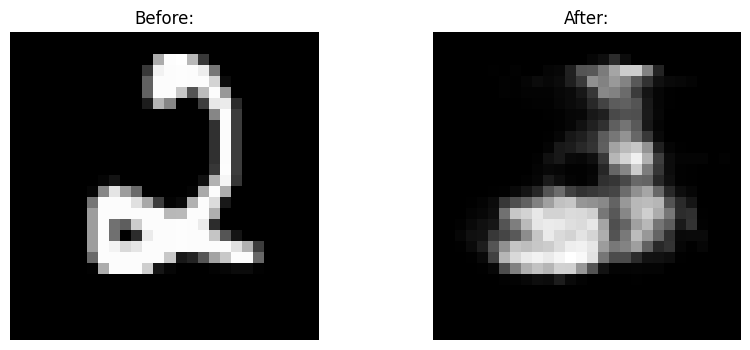

In [23]:
model = torch.jit.load('model_AE.pt')
index = 0
model.cuda()
with torch.no_grad():
    for images, _ in full_dataloaders['val']:
        images = images.to(device)
        images = images.view(images.size(0), -1)
        
        outputs = model(images)
        print(len(outputs))
        print(outputs.shape)
        plot_two_tensors(images[index].cpu().view(28,28), outputs[index].cpu().view(28,28))
        break


### abnormal detection

In [40]:
model = torch.jit.load('model_AE.pt').cuda()
best_acc = 0
best_anomaly_threshold = 0
criterion = torch.nn.MSELoss(reduction='none')

loss_min = 1
loss_max = 0
for images, labels in full_dataloaders['val']:
    images = images.to(device)
    labels = labels.to(device)
    images = images.view(images.size(0), -1)

    outputs = model(images)

    loss = criterion(outputs, images).mean(dim=1)  # Get per image loss
    if loss.min() < loss_min:
        loss_min = loss.min()
    if loss.max() > loss_max:
        loss_max = loss.max()

thresholds = np.linspace(loss_min.cpu().detach().numpy(), loss_max.cpu().detach().numpy(), num=50)


for anomaly_threshold in thresholds:
    # anomaly_threshold = ii / float(segment_size)

    model.eval()
    total, correct = 0, 0
    losses = []
    with torch.no_grad():
        for images, labels in full_dataloaders['val']:
            images = images.to(device)
            labels = labels.to(device)
            images = images.view(images.size(0), -1)

            outputs = model(images)

            # Calculate loss per image (mean across each image's feature dimension)
            loss = criterion(outputs, images).mean(dim=1)  # Get per image loss
            
            anomaly_mask = loss > anomaly_threshold

            is_normal = torch.isin(labels, normal_labels)

            correct_preds = (~is_normal & anomaly_mask) | (is_normal & ~anomaly_mask)
            correct += correct_preds.sum().item()
            total += labels.size(0)
            
        accuracy = 100 * correct / total
        if accuracy > best_acc:
            best_acc = accuracy
            best_anomaly_threshold = anomaly_threshold
        print(f'Anomaly detection accuracy: {accuracy:.2f}% at threshold: {anomaly_threshold}')

print(f'Best anomaly detection accuracy: {best_acc:.2f}% at threshold: {best_anomaly_threshold}')


Anomaly detection accuracy: 59.37% at threshold: 0.0006870387005619705
Anomaly detection accuracy: 67.52% at threshold: 0.003437556345395896
Anomaly detection accuracy: 72.36% at threshold: 0.006188073990229821
Anomaly detection accuracy: 77.07% at threshold: 0.008938591635063747
Anomaly detection accuracy: 82.08% at threshold: 0.011689109279897672
Anomaly detection accuracy: 86.38% at threshold: 0.014439626924731597
Anomaly detection accuracy: 88.48% at threshold: 0.017190144569565524
Anomaly detection accuracy: 88.66% at threshold: 0.019940662214399447
Anomaly detection accuracy: 87.03% at threshold: 0.022691179859233374
Anomaly detection accuracy: 84.44% at threshold: 0.0254416975040673
Anomaly detection accuracy: 80.46% at threshold: 0.028192215148901224
Anomaly detection accuracy: 76.34% at threshold: 0.03094273279373515
Anomaly detection accuracy: 71.68% at threshold: 0.03369325043856908
Anomaly detection accuracy: 67.28% at threshold: 0.036443768083403
Anomaly detection accuracy

## 3. Denoising Autoencoder

In [60]:
class Denoise_Autoencoder(nn.Module):
    def __init__(self):
        super(Denoise_Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
        )
        self.decoder = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Sigmoid activation to output values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


### Train Denoising Autoencoder

In [42]:
def add_noise(imgs, noise_factor=0.5):
    noisy_imgs = imgs + noise_factor * torch.randn_like(imgs)
    noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)
    return noisy_imgs

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Denoise_Autoencoder().to(device)
print(f"Model: Denoise_Autoencoder")
model_parameters_amount = count_parameters(model)
print(f"model total parameters: {model_parameters_amount:,}")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20

for epoch in range(epochs):
    model.train()
    correct, total = 0, 0
    running_loss = 0.0
    for images, _ in tqdm(dataloaders['train']):
        images = images.to(device)
        noisy_images = add_noise(images)

        images = images.view(images.size(0), -1)
        noisy_images = noisy_images.view(noisy_images.size(0), -1)

        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total += images.size(0)
        running_loss += loss.item()


    print(f'Epoch {epoch+1}\n[TRAIN] Loss: {running_loss / total}')

    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    with torch.no_grad():
        for images, _ in tqdm(dataloaders['val']):
            images = images.to(device)
            noisy_images = add_noise(images)
            images = images.view(images.size(0), -1)
            noisy_images = noisy_images.view(images.size(0), -1)
            
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            total += images.size(0)
            running_loss += loss.item()

    print(f'[VALID] Loss: {running_loss / total}\n')

model_scripted = torch.jit.script(model.cpu()) # Export to TorchScript
model_scripted.save('model_DAE.pt') # Save

Model: Denoise_Autoencoder
model total parameters: 219,804


100%|██████████| 307/307 [00:02<00:00, 111.23it/s]


Epoch 1
[TRAIN] Loss: 0.0010284853066437334


100%|██████████| 77/77 [00:00<00:00, 150.98it/s]


[VALID] Loss: 0.0008121350012622556



100%|██████████| 307/307 [00:02<00:00, 116.73it/s]


Epoch 2
[TRAIN] Loss: 0.0006578301979323565


100%|██████████| 77/77 [00:00<00:00, 145.27it/s]


[VALID] Loss: 0.0005633040037042543



100%|██████████| 307/307 [00:02<00:00, 116.29it/s]


Epoch 3
[TRAIN] Loss: 0.0005255455003588013


100%|██████████| 77/77 [00:00<00:00, 187.80it/s]


[VALID] Loss: 0.00048730962648866423



100%|██████████| 307/307 [00:02<00:00, 113.28it/s]


Epoch 4
[TRAIN] Loss: 0.00046135660894406613


100%|██████████| 77/77 [00:00<00:00, 183.33it/s]


[VALID] Loss: 0.0004413075110319917



100%|██████████| 307/307 [00:02<00:00, 113.70it/s]


Epoch 5
[TRAIN] Loss: 0.0004234699993239545


100%|██████████| 77/77 [00:00<00:00, 256.67it/s]


[VALID] Loss: 0.00041090556214099406



100%|██████████| 307/307 [00:02<00:00, 115.85it/s]


Epoch 6
[TRAIN] Loss: 0.000399874144628581


100%|██████████| 77/77 [00:00<00:00, 135.09it/s]


[VALID] Loss: 0.00039327058771242927



100%|██████████| 307/307 [00:02<00:00, 112.86it/s]


Epoch 7
[TRAIN] Loss: 0.0003820027337490757


100%|██████████| 77/77 [00:00<00:00, 174.98it/s]


[VALID] Loss: 0.00037480371621974323



100%|██████████| 307/307 [00:02<00:00, 113.28it/s]


Epoch 8
[TRAIN] Loss: 0.00036901623145638515


100%|██████████| 77/77 [00:00<00:00, 163.82it/s]


[VALID] Loss: 0.00036592562857360036



100%|██████████| 307/307 [00:02<00:00, 114.13it/s]


Epoch 9
[TRAIN] Loss: 0.00035707678886845


100%|██████████| 77/77 [00:00<00:00, 171.11it/s]


[VALID] Loss: 0.00035363680141574496



100%|██████████| 307/307 [00:02<00:00, 118.99it/s]


Epoch 10
[TRAIN] Loss: 0.0003475223943282431


100%|██████████| 77/77 [00:00<00:00, 240.63it/s]


[VALID] Loss: 0.00034501639434442844



100%|██████████| 307/307 [00:02<00:00, 130.08it/s]


Epoch 11
[TRAIN] Loss: 0.00033724811203990536


100%|██████████| 77/77 [00:00<00:00, 202.63it/s]


[VALID] Loss: 0.00033786315402677374



100%|██████████| 307/307 [00:02<00:00, 124.80it/s]


Epoch 12
[TRAIN] Loss: 0.00032953397412257516


100%|██████████| 77/77 [00:00<00:00, 226.46it/s]


[VALID] Loss: 0.00032975660228998634



100%|██████████| 307/307 [00:02<00:00, 123.29it/s]


Epoch 13
[TRAIN] Loss: 0.00032149968564437536


100%|██████████| 77/77 [00:00<00:00, 256.67it/s]


[VALID] Loss: 0.00031943138118481403



100%|██████████| 307/307 [00:02<00:00, 118.99it/s]


Epoch 14
[TRAIN] Loss: 0.00031530953825791263


100%|██████████| 77/77 [00:00<00:00, 197.45it/s]


[VALID] Loss: 0.00031342196349564224



100%|██████████| 307/307 [00:02<00:00, 118.53it/s]


Epoch 15
[TRAIN] Loss: 0.0003098587085957314


100%|██████████| 77/77 [00:00<00:00, 171.10it/s]


[VALID] Loss: 0.00030801516042943403



100%|██████████| 307/307 [00:02<00:00, 118.08it/s]


Epoch 16
[TRAIN] Loss: 0.0003046230106086605


100%|██████████| 77/77 [00:00<00:00, 179.05it/s]


[VALID] Loss: 0.0003037511186025042



100%|██████████| 307/307 [00:02<00:00, 116.73it/s]


Epoch 17
[TRAIN] Loss: 0.00030021038121237745


100%|██████████| 77/77 [00:00<00:00, 142.59it/s]


[VALID] Loss: 0.00030066779718342985



100%|██████████| 307/307 [00:02<00:00, 115.85it/s]


Epoch 18
[TRAIN] Loss: 0.0002965340437256162


100%|██████████| 77/77 [00:00<00:00, 174.99it/s]


[VALID] Loss: 0.00029523554997494387



100%|██████████| 307/307 [00:02<00:00, 116.29it/s]


Epoch 19
[TRAIN] Loss: 0.00029176204360237664


100%|██████████| 77/77 [00:00<00:00, 202.64it/s]


[VALID] Loss: 0.00029333791747106794



100%|██████████| 307/307 [00:02<00:00, 121.34it/s]


Epoch 20
[TRAIN] Loss: 0.0002882516031694508


100%|██████████| 77/77 [00:00<00:00, 179.07it/s]

[VALID] Loss: 0.00029264548558329234



### Result Visualization

In [46]:
def plot_three_tensors(tensor1, tensor2, tensor3):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))  # Create a figure with two subplots

    axes[0].imshow(tensor1.squeeze(), cmap='gray')  # Remove channel dimension if exists and plot
    axes[0].set_title(f'Before:')
    axes[0].axis('off')  # Hide axes ticks

    axes[1].imshow(tensor2.squeeze(), cmap='gray')
    axes[1].set_title(f'Add Noise:')
    axes[1].axis('off')

    axes[2].imshow(tensor3.squeeze(), cmap='gray')
    axes[2].set_title(f'After:')
    axes[2].axis('off')
    plt.show()

Label: 9
torch.Size([64, 784])


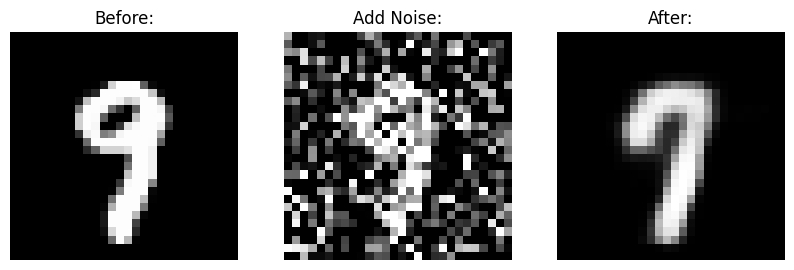

In [55]:
model = torch.jit.load('model_DAE.pt').cuda()
index = 2
model.cuda()
with torch.no_grad():
    for images, label in full_dataloaders['val']:
        images = images.to(device)
        noisy_images = add_noise(images)
        images = images.view(images.size(0), -1)
        noisy_images = noisy_images.view(noisy_images.size(0), -1)
        
        outputs = model(noisy_images)
        print("Label:", label[index].item())
        print(outputs.shape)
        plot_three_tensors(images[index].cpu().view(28,28), noisy_images[index].cpu().view(28,28), outputs[index].cpu().view(28,28))
        break

### abnormal detection

In [43]:
model = torch.jit.load('model_DAE.pt').cuda()
best_acc = 0
best_anomaly_threshold = 0

criterion = torch.nn.MSELoss(reduction='none')

loss_min = 1
loss_max = 0
for images, labels in full_dataloaders['val']:
    images = images.to(device)
    labels = labels.to(device)
    images = images.view(images.size(0), -1)

    outputs = model(images)

    loss = criterion(outputs, images).mean(dim=1)  # Get per image loss
    if loss.min() < loss_min:
        loss_min = loss.min()
    if loss.max() > loss_max:
        loss_max = loss.max()

thresholds = np.linspace(loss_min.cpu().detach().numpy(), loss_max.cpu().detach().numpy(), num=50)

for anomaly_threshold in thresholds:

    model.eval()
    total, correct = 0, 0
    losses = []
    with torch.no_grad():
        for images, labels in full_dataloaders['val']:
            images = images.to(device)
            noisy_images = add_noise(images)
            labels = labels.to(device)
            
            images = images.view(images.size(0), -1)
            noisy_images = noisy_images.view(noisy_images.size(0), -1)

            outputs = model(noisy_images)

            # Calculate loss per image (mean across each image's feature dimension)
            loss = criterion(outputs, images).mean(dim=1)  # Get per image loss
            
            anomaly_mask = loss > anomaly_threshold

            is_normal = torch.isin(labels, normal_labels)

            correct_preds = (~is_normal & anomaly_mask) | (is_normal & ~anomaly_mask)
            correct += correct_preds.sum().item()
            total += labels.size(0)
            
        accuracy = 100 * correct / total
        if accuracy > best_acc:
            best_acc = accuracy
            best_anomaly_threshold = anomaly_threshold
        print(f'Anomaly detection accuracy: {accuracy:.2f}% at threshold: {anomaly_threshold}')

print(f'Best anomaly detection accuracy: {best_acc:.2f}% at threshold: {best_anomaly_threshold}')


Anomaly detection accuracy: 59.38% at threshold: 0.00196940079331398
Anomaly detection accuracy: 61.62% at threshold: 0.004442765852626489
Anomaly detection accuracy: 65.92% at threshold: 0.006916130911938998
Anomaly detection accuracy: 69.47% at threshold: 0.009389495971251507
Anomaly detection accuracy: 72.02% at threshold: 0.011862861030564015
Anomaly detection accuracy: 75.02% at threshold: 0.014336226089876523
Anomaly detection accuracy: 77.96% at threshold: 0.016809591149189035
Anomaly detection accuracy: 81.05% at threshold: 0.019282956208501543
Anomaly detection accuracy: 83.58% at threshold: 0.02175632126781405
Anomaly detection accuracy: 85.59% at threshold: 0.02422968632712656
Anomaly detection accuracy: 86.49% at threshold: 0.026703051386439067
Anomaly detection accuracy: 86.58% at threshold: 0.029176416445751578
Anomaly detection accuracy: 85.71% at threshold: 0.03164978150506409
Anomaly detection accuracy: 83.92% at threshold: 0.034123146564376594
Anomaly detection accura

## 4. Variational autoencoder

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, 400)
        self.fc_mean = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)
        # Decoder
        self.fc2 = nn.Linear(latent_dim, 400)
        self.fc3 = nn.Linear(400, input_dim)
    
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc_mean(h1), self.fc_logvar(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        h2 = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))  # Assuming input is 28x28 (for MNIST)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


### Train VAE

In [69]:
def vae_loss(recon_x, x, mu, logvar):
    assert torch.max(recon_x) <= 1 and torch.min(recon_x) >= 0, "Recon_x out of bounds"
    assert torch.max(x) <= 1 and torch.min(x) >= 0, "x out of bounds"
    
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KL


In [33]:
device = 'cuda'
latent_dim = 20  # Latent dimensionality
input_dim = 784  # 28x28 images flattened
model = VAE(input_dim,latent_dim).to(device)
print(f"Model: VAE")
model_parameters_amount = count_parameters(model)
print(f"model total parameters: {model_parameters_amount:,}")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20

for epoch in range(epochs):
    model.train()
    correct, total = 0, 0
    running_loss = 0.0
    for images, _ in tqdm(dataloaders['train']):
        images = images.to(device)
        images = images.view(images.size(0), -1)

        recon_batch, mu, logvar = model(images)
        loss = vae_loss(recon_batch, images, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total += images.size(0)
        running_loss += loss.item()


    print(f'Epoch {epoch+1}\n[TRAIN] Loss: {running_loss / total}')

    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    with torch.no_grad():
        for images, _ in tqdm(dataloaders['val']):
            images = images.to(device)
            images = images.view(images.size(0), -1)
            
            recon_batch, mu, logvar = model(images)
            loss = vae_loss(recon_batch, images, mu, logvar)
            total += images.size(0)
            running_loss += loss.item()

    print(f'[VALID] Loss: {running_loss / total}\n')
model_scripted = torch.jit.script(model.cpu()) # Export to TorchScript
model_scripted.save('model_VAE.pt') # Save

Model: VAE
model total parameters: 652,824


100%|██████████| 307/307 [00:03<00:00, 100.65it/s]


Epoch 1
[TRAIN] Loss: 159.62365673572143


100%|██████████| 77/77 [00:00<00:00, 167.39it/s]


[VALID] Loss: 124.3431087332362



100%|██████████| 307/307 [00:02<00:00, 103.02it/s]


Epoch 2
[TRAIN] Loss: 115.97339445013074


100%|██████████| 77/77 [00:00<00:00, 183.33it/s]


[VALID] Loss: 110.03504511432462



100%|██████████| 307/307 [00:02<00:00, 102.68it/s]


Epoch 3
[TRAIN] Loss: 106.55921705603909


100%|██████████| 77/77 [00:00<00:00, 197.43it/s]


[VALID] Loss: 104.30408907713253



100%|██████████| 307/307 [00:02<00:00, 107.34it/s]


Epoch 4
[TRAIN] Loss: 101.97458106776003


100%|██████████| 77/77 [00:00<00:00, 154.00it/s]


[VALID] Loss: 100.54721228385205



100%|██████████| 307/307 [00:02<00:00, 110.83it/s]


Epoch 5
[TRAIN] Loss: 99.14669644319902


100%|██████████| 77/77 [00:00<00:00, 153.99it/s]


[VALID] Loss: 98.47272812038757



100%|██████████| 307/307 [00:02<00:00, 108.87it/s]


Epoch 6
[TRAIN] Loss: 97.14220603018272


100%|██████████| 77/77 [00:00<00:00, 226.47it/s]


[VALID] Loss: 96.91359022308251



100%|██████████| 307/307 [00:02<00:00, 105.86it/s]


Epoch 7
[TRAIN] Loss: 95.90626334590682


100%|██████████| 77/77 [00:00<00:00, 167.39it/s]


[VALID] Loss: 95.82907611461727



100%|██████████| 307/307 [00:02<00:00, 110.83it/s]


Epoch 8
[TRAIN] Loss: 94.77211968489941


100%|██████████| 77/77 [00:00<00:00, 192.49it/s]


[VALID] Loss: 94.93993375200402



100%|██████████| 307/307 [00:02<00:00, 112.87it/s]


Epoch 9
[TRAIN] Loss: 94.07595066100264


100%|██████████| 77/77 [00:00<00:00, 150.98it/s]


[VALID] Loss: 94.57755252204423



100%|██████████| 307/307 [00:02<00:00, 112.04it/s]


Epoch 10
[TRAIN] Loss: 93.4466006409614


100%|██████████| 77/77 [00:00<00:00, 171.12it/s]


[VALID] Loss: 93.89971695194804



100%|██████████| 307/307 [00:02<00:00, 115.41it/s]


Epoch 11
[TRAIN] Loss: 92.92318543384486


100%|██████████| 77/77 [00:00<00:00, 163.82it/s]


[VALID] Loss: 93.49599305193277



100%|██████████| 307/307 [00:02<00:00, 111.23it/s]


Epoch 12
[TRAIN] Loss: 92.40576626679646


100%|██████████| 77/77 [00:00<00:00, 208.10it/s]


[VALID] Loss: 93.03425632936559



100%|██████████| 307/307 [00:02<00:00, 121.83it/s]


Epoch 13
[TRAIN] Loss: 92.0338864503407


100%|██████████| 77/77 [00:00<00:00, 197.43it/s]


[VALID] Loss: 92.83527853900524



100%|██████████| 307/307 [00:02<00:00, 113.29it/s]


Epoch 14
[TRAIN] Loss: 91.69711799988548


100%|██████████| 77/77 [00:00<00:00, 192.49it/s]


[VALID] Loss: 92.52539609231856



100%|██████████| 307/307 [00:02<00:00, 114.55it/s]


Epoch 15
[TRAIN] Loss: 91.38210084256662


100%|██████████| 77/77 [00:00<00:00, 233.32it/s]


[VALID] Loss: 92.37054453299955



100%|██████████| 307/307 [00:02<00:00, 105.86it/s]


Epoch 16
[TRAIN] Loss: 91.11261579375986


100%|██████████| 77/77 [00:00<00:00, 197.43it/s]


[VALID] Loss: 92.26981177314485



100%|██████████| 307/307 [00:02<00:00, 106.23it/s]


Epoch 17
[TRAIN] Loss: 90.85300967347113


100%|██████████| 77/77 [00:00<00:00, 183.34it/s]


[VALID] Loss: 92.17168374325631



100%|██████████| 307/307 [00:02<00:00, 119.92it/s]


Epoch 18
[TRAIN] Loss: 90.68046181112257


100%|██████████| 77/77 [00:00<00:00, 160.43it/s]


[VALID] Loss: 91.83411817519595



100%|██████████| 307/307 [00:02<00:00, 125.30it/s]


Epoch 19
[TRAIN] Loss: 90.45532051350874


100%|██████████| 77/77 [00:00<00:00, 183.31it/s]


[VALID] Loss: 91.7094604293376



100%|██████████| 307/307 [00:02<00:00, 124.80it/s]


Epoch 20
[TRAIN] Loss: 90.27012734231849


100%|██████████| 77/77 [00:00<00:00, 183.36it/s]

[VALID] Loss: 91.31622105700961



### Result Visualization

torch.Size([64, 784])


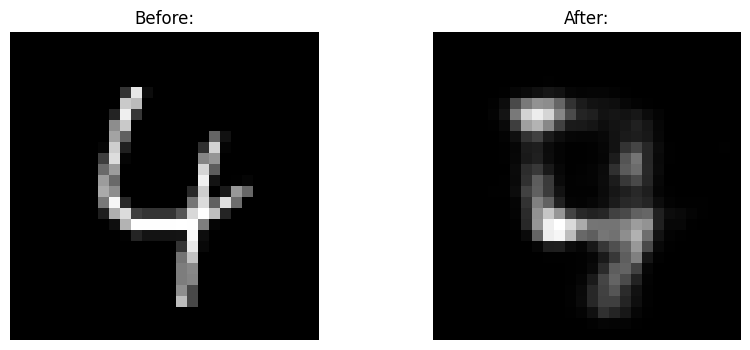

In [15]:
model = torch.jit.load("model_VAE.pt").cuda()
index = 4
model.cuda()

with torch.no_grad():
    for images, _ in full_dataloaders['val']:
        images = images.to(device)
        images = images.view(images.size(0), -1)
        
        recon_batch, mu, logvar = model(images)
        print(recon_batch.shape)
        plot_two_tensors(images[index].cpu().view(28,28), recon_batch[index].cpu().view(28,28))
        break


### abnormal detection

In [44]:
model = torch.jit.load("model_VAE.pt").cuda()
best_acc = 0
best_anomaly_threshold = 0
normal_labels = torch.tensor([1, 3, 5, 7], device=device)
criterion = torch.nn.MSELoss(reduction='none')


loss_min = 1
loss_max = 0
for images, labels in full_dataloaders['val']:
    images = images.to(device)
    labels = labels.to(device)
    images = images.view(images.size(0), -1)

    recon_batch, mu, logvar = model(images)

    loss = criterion(recon_batch, images).mean(dim=1)  # Get per image loss
    if loss.min() < loss_min:
        loss_min = loss.min()
    if loss.max() > loss_max:
        loss_max = loss.max()

thresholds = np.linspace(loss_min.cpu().detach().numpy(), loss_max.cpu().detach().numpy(), num=50)

for anomaly_threshold in thresholds:
    model.eval()
    total, correct = 0, 0
    losses = []
    with torch.no_grad():
        for images, labels in full_dataloaders['val']:
            images = images.to(device)
            labels = labels.to(device)
            images = images.view(images.size(0), -1)

            recon_batch, mu, logvar = model(images)
            # Calculate loss per image (mean across each image's feature dimension)
            loss = criterion(recon_batch, images).mean(dim=1)  # Get per image loss
            # loss = vae_loss(recon_batch, images, mu, logvar)
            anomaly_mask = loss > anomaly_threshold

            is_normal = torch.isin(labels, normal_labels)

            correct_preds = (~is_normal & anomaly_mask) | (is_normal & ~anomaly_mask)
            correct += correct_preds.sum().item()
            total += labels.size(0)

        accuracy = 100 * correct / total
        if accuracy > best_acc:
            best_acc = accuracy
            best_anomaly_threshold = anomaly_threshold
        print(f'Anomaly detection accuracy: {accuracy:.2f}% at threshold: {anomaly_threshold}')

print(f'Best anomaly detection accuracy: {best_acc:.2f}% at threshold: {best_anomaly_threshold}')


Anomaly detection accuracy: 59.37% at threshold: 0.0009143076604232192
Anomaly detection accuracy: 60.43% at threshold: 0.002594370508984644
Anomaly detection accuracy: 64.54% at threshold: 0.0042744333575460685
Anomaly detection accuracy: 68.88% at threshold: 0.005954496206107492
Anomaly detection accuracy: 72.67% at threshold: 0.007634559054668917
Anomaly detection accuracy: 76.78% at threshold: 0.009314621903230342
Anomaly detection accuracy: 80.51% at threshold: 0.010994684751791765
Anomaly detection accuracy: 83.61% at threshold: 0.012674747600353191
Anomaly detection accuracy: 85.28% at threshold: 0.014354810448914615
Anomaly detection accuracy: 85.38% at threshold: 0.01603487329747604
Anomaly detection accuracy: 84.89% at threshold: 0.017714936146037464
Anomaly detection accuracy: 83.08% at threshold: 0.01939499899459889
Anomaly detection accuracy: 80.62% at threshold: 0.02107506184316031
Anomaly detection accuracy: 77.17% at threshold: 0.022755124691721737
Anomaly detection acc

## 5. Isolated Forrest

### Convert Pytorch dataset to sklearn dataset

In [10]:
X = full_dataset.data.numpy().reshape(len(full_dataset), -1)
y = full_dataset.targets.numpy()
print(X.shape)

(60000, 784)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X , y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 0.1111 * 0.9 = 0.1


In [12]:
print("------------")
print("Train dataset shape")
print(X_train.shape)
print(y_train.shape)


print("------------")
print("Val dataset shape")
print(X_val.shape)
print(y_val.shape)


print("------------")
print("Test dataset shape")
print(X_test.shape)
print(y_test.shape)

------------
Train dataset shape
(48000, 784)
(48000,)
------------
Val dataset shape
(6000, 784)
(6000,)
------------
Test dataset shape
(6000, 784)
(6000,)


### Train isolated forest

In [81]:
X_full = full_dataset.data.numpy().reshape(len(full_dataset), -1)  # Flatten the images
y_full = full_dataset.targets.numpy()

# Filter the dataset to only have digits 1, 3, 5, 7
target_digits = [1, 3, 5, 7]
mask = np.isin(y_full, target_digits)
X_train_mask = X_full[mask]
y_train_mask = y_full[mask]

# Train Isolation Forest on digits 1, 3, 5, 7
clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.4, random_state=42)
clf.fit(X_train_mask)

# Use the trained model to predict over the full dataset
y_pred = clf.predict(X_full)

print("------------------")
print(f"Total number of data: {len(y_full)}")
print(f"Total number of normal data: {len(y_train_mask)}")
print(f"Total number of abnormal data: {len(y_full) - len(y_train_mask)}")
print("------------------")
abnormal_indices = np.where(y_pred == -1)[0]
normal_indices = np.where(y_pred == 1)[0]
print("Number of abnormalities detected:", len(abnormal_indices))
print("Number of normalities detected:", len(normal_indices))

abnormal_digits = y_full[abnormal_indices]
normal_digits = y_full[normal_indices]

# You might want to check how many of the abnormal detections are actually from digits other than 1, 3, 5, 7
actual_abnormals = np.isin(abnormal_digits, target_digits, invert=True)
actual_normals = np.isin(normal_digits, target_digits)
# print(np.sum(actual_abnormals))
# print(np.sum(actual_normals))
print(f"accuracy: {(np.sum(actual_abnormals) + np.sum(actual_normals)) * 100 / len(y_full)} %")


------------------
Total number of data: 60000
Total number of normal data: 24559
Total number of abnormal data: 35441
------------------
Number of abnormalities detected: 37140
Number of normalities detected: 22860
accuracy: 70.085 %


### abnormal detection

In [82]:
# Obtain anomaly scores (the lower, the more abnormal)
scores = clf.decision_function(X_full)

# Define a range of thresholds from the anomaly scores to classify as normal or abnormal
thresholds = np.linspace(scores.min(), scores.max(), num=50)
print("------------------")
best_acc = 0 
best_threshold = 0
# Evaluate accuracy at each threshold
for threshold in thresholds:
    y_pred = np.where(scores < threshold, -1, 1)

    abnormal_indices = np.where(y_pred == -1)[0]
    normal_indices = np.where(y_pred == 1)[0]

    abnormal_digits = y_full[abnormal_indices]
    normal_digits = y_full[normal_indices]

    # Check how many detected abnormalities are actual abnormalities
    actual_abnormals = np.isin(abnormal_digits, target_digits, invert=True)
    actual_normals = np.isin(normal_digits, target_digits)

    accuracy = (np.sum(actual_abnormals) + np.sum(actual_normals)) / len(y_full) * 100
    if accuracy > best_acc:
        best_acc = accuracy
        best_threshold = threshold
    print(f"Threshold: {threshold:.3f} --> Detected abnormalities: {len(abnormal_indices)}, Detected normals: {len(normal_indices)}, Accuracy: {accuracy:.2f}%")
print(f"The best threshold: {best_threshold}, with Accuracy: {best_acc}%")

------------------
Threshold: -0.247 --> Detected abnormalities: 0, Detected normals: 60000, Accuracy: 40.93%
Threshold: -0.240 --> Detected abnormalities: 1, Detected normals: 59999, Accuracy: 40.93%
Threshold: -0.233 --> Detected abnormalities: 2, Detected normals: 59998, Accuracy: 40.94%
Threshold: -0.226 --> Detected abnormalities: 3, Detected normals: 59997, Accuracy: 40.94%
Threshold: -0.219 --> Detected abnormalities: 4, Detected normals: 59996, Accuracy: 40.94%
Threshold: -0.212 --> Detected abnormalities: 12, Detected normals: 59988, Accuracy: 40.95%
Threshold: -0.205 --> Detected abnormalities: 22, Detected normals: 59978, Accuracy: 40.97%
Threshold: -0.198 --> Detected abnormalities: 44, Detected normals: 59956, Accuracy: 41.01%
Threshold: -0.191 --> Detected abnormalities: 92, Detected normals: 59908, Accuracy: 41.08%
Threshold: -0.184 --> Detected abnormalities: 154, Detected normals: 59846, Accuracy: 41.18%
Threshold: -0.177 --> Detected abnormalities: 259, Detected norma

## 6. Isolated Forrest with pre-trained feature extractor.

In [34]:
def fit_with_clf(features, y_full):
    X_full = features  # Flatten the images

    target_digits = [1, 3, 5, 7]
    mask = np.isin(y_full, target_digits)
    X_train_mask = X_full[mask]
    y_train_mask = y_full[mask]

    # Train Isolation Forest on digits 1, 3, 5, 7
    clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.5, random_state=42)
    clf.fit(X_train_mask)

    # Use the trained model to predict over the full dataset
    y_pred = clf.predict(X_full)

    print("------------------")
    print(f"Total number of data: {len(y_full)}")
    print(f"Total number of normal data: {len(y_train_mask)}")
    print(f"Total number of abnormal data: {len(y_full) - len(y_train_mask)}")
    print("------------------")
    abnormal_indices = np.where(y_pred == -1)[0]
    normal_indices = np.where(y_pred == 1)[0]
    print("Number of abnormalities detected:", len(abnormal_indices))
    print("Number of normalities detected:", len(normal_indices))

    abnormal_digits = y_full[abnormal_indices]
    normal_digits = y_full[normal_indices]

    # You might want to check how many of the abnormal detections are actually from digits other than 1, 3, 5, 7
    actual_abnormals = np.isin(abnormal_digits, target_digits, invert=True)
    actual_normals = np.isin(normal_digits, target_digits)
    # print(np.sum(actual_abnormals))
    # print(np.sum(actual_normals))
    print(f"accuracy: {(np.sum(actual_abnormals) + np.sum(actual_normals)) * 100 / len(y_full)} %")

In [72]:
def fit_with_different_th(features, y_full):
    X_full = features
    target_digits = [1, 3, 5, 7]
    mask = np.isin(y_full, target_digits)
    X_train_mask = X_full[mask]
    # y_train_mask = y_full[mask]

    clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.4, random_state=42)
    clf.fit(X_train_mask)
    # Obtain anomaly scores (the lower, the more abnormal)
    scores = clf.decision_function(X_full)

    # Define a range of thresholds from the anomaly scores to classify as normal or abnormal
    thresholds = np.linspace(scores.min(), scores.max(), num=50)
    print("------------------")
    best_acc = 0 
    best_threshold = 0
    # Evaluate accuracy at each threshold
    for threshold in thresholds:
        y_pred = np.where(scores < threshold, -1, 1)

        abnormal_indices = np.where(y_pred == -1)[0]
        normal_indices = np.where(y_pred == 1)[0]

        abnormal_digits = y_full[abnormal_indices]
        normal_digits = y_full[normal_indices]

        # Check how many detected abnormalities are actual abnormalities
        actual_abnormals = np.isin(abnormal_digits, target_digits, invert=True)
        actual_normals = np.isin(normal_digits, target_digits)

        accuracy = (np.sum(actual_abnormals) + np.sum(actual_normals)) / len(y_full) * 100
        if accuracy > best_acc:
            best_acc = accuracy
            best_threshold = threshold
        print(f"Threshold: {threshold:.3f} --> Detected abnormalities: {len(abnormal_indices)}, Detected normals: {len(normal_indices)}, Accuracy: {accuracy:.2f}%")
    print(f"The best threshold: {best_threshold}, with Accuracy: {best_acc}%")

### Image classifier as feature extractor

In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.jit.load('model_image_classifier.pt')
model = DigitClassifier().to(device)
model.load_state_dict(model.state_dict())
model = model.cuda()
model.fc = nn.Identity()
print(f"Model: DigitClassifier")
model_parameters_amount = count_parameters(model)
print(f"model total parameters: {model_parameters_amount:,}")

model.eval()
features = []
forest_labels = []
with torch.no_grad():
    for phase in ['train', 'val', 'test']:
        for images, labels in tqdm(full_dataloaders[phase]):
            # labels = transform_labels(labels)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            features.append(outputs.cpu().numpy())
            forest_labels.append(labels.cpu().numpy())
            # print(outputs[1])
            # break
features = np.concatenate(features, axis=0)
forest_labels = np.concatenate(forest_labels, axis=0)

print(features.shape)
print(forest_labels.shape)

Model: DigitClassifier
model total parameters: 205,632


  4%|▍         | 32/750 [00:00<00:04, 151.11it/s]

100%|██████████| 188/188 [00:01<00:00, 164.98it/s]
0it [00:00, ?it/s]

(60000, 128)
(60000,)


In [74]:
fit_with_clf(features, forest_labels)
fit_with_different_th(features, forest_labels)

------------------
Total number of data: 60000
Total number of normal data: 24559
Total number of abnormal data: 35441
------------------
Number of abnormalities detected: 42059
Number of normalities detected: 17941
accuracy: 70.1 %
------------------
Threshold: -0.155 --> Detected abnormalities: 0, Detected normals: 60000, Accuracy: 40.93%
Threshold: -0.151 --> Detected abnormalities: 2, Detected normals: 59998, Accuracy: 40.94%
Threshold: -0.147 --> Detected abnormalities: 5, Detected normals: 59995, Accuracy: 40.94%
Threshold: -0.142 --> Detected abnormalities: 9, Detected normals: 59991, Accuracy: 40.95%
Threshold: -0.138 --> Detected abnormalities: 16, Detected normals: 59984, Accuracy: 40.96%
Threshold: -0.134 --> Detected abnormalities: 30, Detected normals: 59970, Accuracy: 40.98%
Threshold: -0.129 --> Detected abnormalities: 55, Detected normals: 59945, Accuracy: 41.02%
Threshold: -0.125 --> Detected abnormalities: 95, Detected normals: 59905, Accuracy: 41.09%
Threshold: -0.12

### Normal autoencoder as feature extractor

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.jit.load('model_AE.pt')
model = Autoencoder().to(device)
model.load_state_dict(model.state_dict())
model = model.cuda()
model.decoder = nn.Identity()
print(f"Model: Autoencoder")
model_parameters_amount = count_parameters(model)
print(f"model total parameters: {model_parameters_amount:,}")

model.eval()
features = []
forest_labels = []
with torch.no_grad():
    for phase in ['train', 'val', 'test']:
        for images, labels in tqdm(full_dataloaders[phase]):
            images = images.view(images.size(0), -1)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            features.append(outputs.cpu().numpy())
            forest_labels.append(labels.cpu().numpy())
features = np.concatenate(features, axis=0)
forest_labels = np.concatenate(forest_labels, axis=0)
print(features.shape)


Model: Autoencoder
model total parameters: 109,516


  4%|▍         | 31/750 [00:00<00:02, 281.82it/s]

100%|██████████| 188/188 [00:00<00:00, 241.03it/s]
0it [00:00, ?it/s]

(60000, 12)


In [76]:
fit_with_clf(features, forest_labels)
fit_with_different_th(features, forest_labels)

------------------
Total number of data: 60000
Total number of normal data: 24559
Total number of abnormal data: 35441
------------------
Number of abnormalities detected: 34817
Number of normalities detected: 25183
accuracy: 58.03 %
------------------
Threshold: -0.225 --> Detected abnormalities: 0, Detected normals: 60000, Accuracy: 40.93%
Threshold: -0.219 --> Detected abnormalities: 1, Detected normals: 59999, Accuracy: 40.93%
Threshold: -0.213 --> Detected abnormalities: 1, Detected normals: 59999, Accuracy: 40.93%
Threshold: -0.207 --> Detected abnormalities: 1, Detected normals: 59999, Accuracy: 40.93%
Threshold: -0.200 --> Detected abnormalities: 5, Detected normals: 59995, Accuracy: 40.94%
Threshold: -0.194 --> Detected abnormalities: 6, Detected normals: 59994, Accuracy: 40.94%
Threshold: -0.188 --> Detected abnormalities: 6, Detected normals: 59994, Accuracy: 40.94%
Threshold: -0.182 --> Detected abnormalities: 12, Detected normals: 59988, Accuracy: 40.95%
Threshold: -0.175 

### Denoising autoencoder as feature extractor

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.jit.load('model_DAE.pt')
model = Denoise_Autoencoder().to(device)
model.load_state_dict(model.state_dict())
model = model.cuda()
model.decoder = nn.Identity()
print(f"Model: Denoise_Autoencoder")
model_parameters_amount = count_parameters(model)
print(f"model total parameters: {model_parameters_amount:,}")

model.eval()
features = []
forest_labels = []
with torch.no_grad():
    for phase in ['train', 'val', 'test']:
        for images, labels in tqdm(full_dataloaders[phase]):
            images = images.view(images.size(0), -1)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            features.append(outputs.cpu().numpy())
            forest_labels.append(labels.cpu().numpy())
features = np.concatenate(features, axis=0)
forest_labels = np.concatenate(forest_labels, axis=0)
print(features.shape)


Model: Denoise_Autoencoder
model total parameters: 109,516


100%|██████████| 188/188 [00:00<00:00, 247.37it/s]
0it [00:00, ?it/s]

(60000, 12)


In [78]:
fit_with_clf(features, forest_labels)
fit_with_different_th(features, forest_labels)

------------------
Total number of data: 60000
Total number of normal data: 24559
Total number of abnormal data: 35441
------------------
Number of abnormalities detected: 41314
Number of normalities detected: 18686
accuracy: 68.85833333333333 %
------------------
Threshold: -0.265 --> Detected abnormalities: 0, Detected normals: 60000, Accuracy: 40.93%
Threshold: -0.258 --> Detected abnormalities: 1, Detected normals: 59999, Accuracy: 40.93%
Threshold: -0.251 --> Detected abnormalities: 1, Detected normals: 59999, Accuracy: 40.93%
Threshold: -0.244 --> Detected abnormalities: 4, Detected normals: 59996, Accuracy: 40.94%
Threshold: -0.237 --> Detected abnormalities: 6, Detected normals: 59994, Accuracy: 40.94%
Threshold: -0.230 --> Detected abnormalities: 11, Detected normals: 59989, Accuracy: 40.95%
Threshold: -0.222 --> Detected abnormalities: 24, Detected normals: 59976, Accuracy: 40.97%
Threshold: -0.215 --> Detected abnormalities: 35, Detected normals: 59965, Accuracy: 40.99%
Thre

### Variational autoencoder as feature extractor

In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.jit.load('model_DAE.pt')
model = VAE(784,20).to(device)
model.load_state_dict(model.state_dict())
model = model.cuda()
model.fc2 = nn.Identity()
model.fc3 = nn.Identity()
print(f"Model: VAE")
model_parameters_amount = count_parameters(model)
print(f"model total parameters: {model_parameters_amount:,}")

model.eval()
features = []
forest_labels = []
with torch.no_grad():
    for phase in ['train', 'val', 'test']:
        for images, labels in tqdm(full_dataloaders[phase]):
            images = images.view(images.size(0), -1)
            images, labels = images.to(device), labels.to(device)
            recon_batch, mu, logvar = model(images)

            features.append(recon_batch.cpu().numpy())
            forest_labels.append(labels.cpu().numpy())
            
features = np.concatenate(features, axis=0)
forest_labels = np.concatenate(forest_labels, axis=0)
print(features.shape)


Model: VAE
model total parameters: 330,040


100%|██████████| 188/188 [00:00<00:00, 216.09it/s]
0it [00:00, ?it/s]

(60000, 20)


In [80]:
fit_with_clf(features, forest_labels)
fit_with_different_th(features, forest_labels)

------------------
Total number of data: 60000
Total number of normal data: 24559
Total number of abnormal data: 35441
------------------
Number of abnormalities detected: 29751
Number of normalities detected: 30249
accuracy: 49.586666666666666 %
------------------
Threshold: -0.163 --> Detected abnormalities: 0, Detected normals: 60000, Accuracy: 40.93%
Threshold: -0.157 --> Detected abnormalities: 2, Detected normals: 59998, Accuracy: 40.93%
Threshold: -0.152 --> Detected abnormalities: 4, Detected normals: 59996, Accuracy: 40.94%
Threshold: -0.146 --> Detected abnormalities: 4, Detected normals: 59996, Accuracy: 40.94%
Threshold: -0.141 --> Detected abnormalities: 9, Detected normals: 59991, Accuracy: 40.94%
Threshold: -0.135 --> Detected abnormalities: 13, Detected normals: 59987, Accuracy: 40.94%
Threshold: -0.130 --> Detected abnormalities: 28, Detected normals: 59972, Accuracy: 40.95%
Threshold: -0.124 --> Detected abnormalities: 54, Detected normals: 59946, Accuracy: 40.94%
Thr

## 7. Comparison and Conclusion